<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_04_auto_ml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Generate Data

In [ ]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v1'

In [2]:
if COLAB:
  !pip install -U featuretools
  # !sudo apt-get install git-lfs && git lfs install
  from google.colab import drive
  drive.mount('/content/gdrive')
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  !cd dl-projects && ls

Requirement already up-to-date: featuretools in /usr/local/lib/python3.6/dist-packages (0.13.1)
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Cloning into 'dl-projects'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 905 (delta 76), reused 14 (delta 8), pack-reused 781
Receiving objects: 100% (905/905), 69.04 MiB | 37.95 MiB/s, done.
Resolving deltas: 100% (524/524), done.
01_01_tensor.ipynb	       04_02_auto_ml_5.ipynb  d02_1_features.ipynb
01_02_correlation.ipynb        04_03_auto_ml_1.ipynb  d03_train_dl.ipynb
01_03_preprocessing.ipynb      04_03_auto_ml_2.ipynb  d04_train_ml.ipynb
01_04_numpy.ipynb	       04_03_auto_ml_3.ipynb  datasets
01_05_parallelization.ipynb    04_04_auto_ml_1.ipynb  exp
01_06_pandas..ipynb	       04_04_auto_ml_2.ipynb  featurelib
01_07_python_0.ipynb	       04_10_basic

In [ ]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [ ]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib
import re

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [ ]:
if COLAB:
  DATASET_PATH = Path("dl-projects/datasets")
else:
  DATASET_PATH = Path("datasets")

DATASET = DATASET_PATH/DATASET_NAME

In [ ]:
data = format_tabular(DATASET)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106858 entries, 0 to 106857
Data columns (total 4 columns):
DrawNo       106858 non-null int64
DrawDate     106858 non-null datetime64[ns]
PrizeType    106858 non-null object
LuckyNo      106858 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


In [10]:
data.tail(24)

,DrawNo,DrawDate,PrizeType,LuckyNo
106834,505219,2019-12-29,SpecialNo9,2528
106835,505320,2020-01-01,1stPrizeNo,875
106836,505320,2020-01-01,2ndPrizeNo,6307
106837,505320,2020-01-01,3rdPrizeNo,8552
106838,505320,2020-01-01,ConsolationNo1,2114
106839,505320,2020-01-01,ConsolationNo10,4861
106840,505320,2020-01-01,ConsolationNo2,508
106841,505320,2020-01-01,ConsolationNo3,2086
106842,505320,2020-01-01,ConsolationNo4,3296
106843,505320,2020-01-01,ConsolationNo5,413


In [ ]:
data['NumberId'] = data['LuckyNo']

In [12]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
106848,505320,2020-01-01,SpecialNo1,2404,2404
106849,505320,2020-01-01,SpecialNo10,7382,7382
106850,505320,2020-01-01,SpecialNo2,2220,2220
106851,505320,2020-01-01,SpecialNo3,3573,3573
106852,505320,2020-01-01,SpecialNo4,4524,4524
106853,505320,2020-01-01,SpecialNo5,6856,6856
106854,505320,2020-01-01,SpecialNo6,8107,8107
106855,505320,2020-01-01,SpecialNo7,1026,1026
106856,505320,2020-01-01,SpecialNo8,3960,3960
106857,505320,2020-01-01,SpecialNo9,5472,5472


## Data Cleansing

In [ ]:
def change_prize_type(x):
  return "Prize"
  # if "Special" in x:
  #   return 'Prize'
  # elif "Consolation" in x:
  #   return 'Prize'
  # else:
  #   return x

def increment_draw_date(x):
  x = x + relativedelta(minutes=1)
  return x

data['PrizeType'] = data['PrizeType'].apply(change_prize_type)

# Add 1 minutes to draw date to avoid overlapping with the cut off date
data['DrawDate'] = data['DrawDate'].apply(increment_draw_date)

In [14]:
data.tail(23)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
106835,505320,2020-01-01 00:01:00,Prize,875,875
106836,505320,2020-01-01 00:01:00,Prize,6307,6307
106837,505320,2020-01-01 00:01:00,Prize,8552,8552
106838,505320,2020-01-01 00:01:00,Prize,2114,2114
106839,505320,2020-01-01 00:01:00,Prize,4861,4861
106840,505320,2020-01-01 00:01:00,Prize,508,508
106841,505320,2020-01-01 00:01:00,Prize,2086,2086
106842,505320,2020-01-01 00:01:00,Prize,3296,3296
106843,505320,2020-01-01 00:01:00,Prize,413,413
106844,505320,2020-01-01 00:01:00,Prize,4781,4781


In [15]:
data.describe().round(2)

,DrawNo,LuckyNo,NumberId
count,106858.00,106858.00,106858.00
mean,273049.89,4973.57,4973.57
std,134131.48,2885.58,2885.58
min,40792.00,0.00,0.00
25%,156899.00,2462.00,2462.00
50%,273056.00,4951.00,4951.00
75%,389213.00,7463.00,7463.00
max,505320.00,9999.00,9999.00


Text(0.5, 1.0, 'Draw')

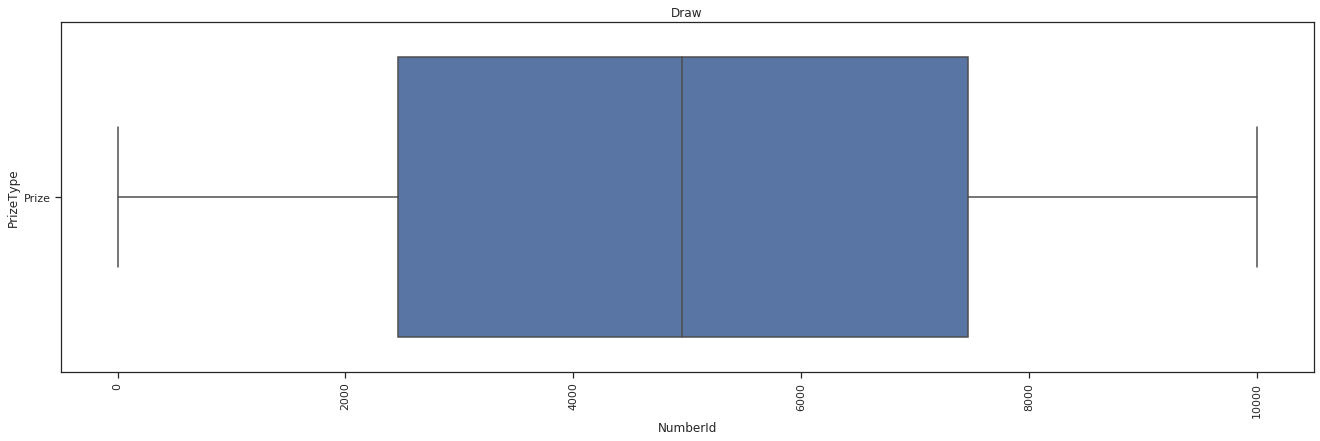

In [16]:
plt.figure(figsize=(20,6))
sns.boxplot(x='NumberId', y='PrizeType',data=data)
plt.xticks(rotation=90)
plt.title('Draw')

# print(data[data['NumberId']==1760])

## Exploration

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

## Making Labels

In [18]:
data['TotalStrike'] = 1
data.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,40792,1992-05-06 00:01:00,Prize,19,19,1
1,40792,1992-05-06 00:01:00,Prize,1124,1124,1
2,40792,1992-05-06 00:01:00,Prize,592,592,1
3,40792,1992-05-06 00:01:00,Prize,5311,5311,1
4,40792,1992-05-06 00:01:00,Prize,407,407,1
5,40792,1992-05-06 00:01:00,Prize,1949,1949,1
6,40792,1992-05-06 00:01:00,Prize,1606,1606,1
7,40792,1992-05-06 00:01:00,Prize,3775,3775,1
8,40792,1992-05-06 00:01:00,Prize,6226,6226,1
9,40792,1992-05-06 00:01:00,Prize,1271,1271,1


In [ ]:
def make_cutoffs(start_date, end_date, threshold=0):
    # Find numbers exist before start date
    number_pool = data[data['DrawDate'] < start_date]['NumberId'].unique()
    tmp = pd.DataFrame({'NumberId': number_pool})
   
    # For numbers in the number pool, find their strike count between the start and end dates
    strike_counts = data[(data['NumberId'].isin(number_pool)) & 
        (data['DrawDate'] >= start_date) & 
        (data['DrawDate']< end_date)
    ].groupby('NumberId')['TotalStrike'].count().reset_index()
    
    number_of_draws = data[
                 (data['DrawDate'] >= start_date) & 
                 (data['DrawDate']< end_date)]['DrawDate'].nunique()
    # display(strike_counts)
    # print(number_of_draws)
    
    # Merge with all the number ids to record all customers who existed before start date
    strike_counts = strike_counts.merge(tmp, on='NumberId', how='right')
    
    # Set the total for any numbers who did not strike in the timeframe equal to 0
    strike_counts['TotalStrike'] = strike_counts['TotalStrike'].fillna(0)
    
    # Label is based on the threshold
    strike_counts['Label'] = (strike_counts['TotalStrike'] > threshold).astype(int)
        
    # The cutoff time is the start date
    strike_counts['cutoff_time'] = pd.to_datetime(start_date)
    strike_counts = strike_counts[['NumberId', 'cutoff_time', 'TotalStrike', 'Label']]
    
    #display(strike_counts[strike_counts['Label']==1].nunique())
    #display(strike_counts.sort_values(by='TotalStrike', ascending=False))
   
    return number_of_draws, strike_counts

In [20]:
number_of_draws, dec_2019 = make_cutoffs(pd.datetime(2019, 12, 1), pd.datetime(2020, 1, 1))
dec_2019[(dec_2019['Label']==1) & (dec_2019['TotalStrike']==2)].sort_values(by='TotalStrike', ascending=False).head()

,NumberId,cutoff_time,TotalStrike,Label
3,135,2019-12-01,2.0,1
86,2513,2019-12-01,2.0,1
167,5030,2019-12-01,2.0,1
189,5740,2019-12-01,2.0,1
192,5864,2019-12-01,2.0,1


In [21]:
data[data['NumberId'].isin([135,2513,5030])]

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
6255,67894,1994-01-27 00:01:00,Prize,2513,2513,1
6994,71194,1994-04-14 00:01:00,Prize,5030,5030,1
9126,80394,1994-11-13 00:01:00,Prize,2513,2513,1
11857,92295,1995-08-19 00:01:00,Prize,2513,2513,1
16285,111596,1996-11-10 00:01:00,Prize,2513,2513,1
19202,124197,1997-08-31 00:01:00,Prize,135,135,1
40002,214703,2003-04-05 00:01:00,Prize,5030,5030,1
46671,243705,2005-01-04 00:01:00,Prize,2513,2513,1
50329,259605,2005-12-10 00:01:00,Prize,2513,2513,1
55421,281707,2007-03-25 00:01:00,Prize,5030,5030,1


Text(0.5, 1.0, 'Label Distribution for May')

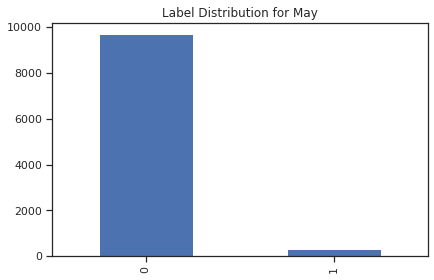

In [22]:
dec_2019['Label'].value_counts().plot.bar()
plt.title('Label Distribution for May')

In [ ]:
CUT_OFF_YEAR=pd.datetime(2012, 1, 1)

In [24]:
## Loop through each month starting from CUT_OFF_YEAR

# print(data['DrawDate'].max())
max_year_month = data['DrawDate'].max() - relativedelta(months=1) + relativedelta(day=31)
print(f"Max month year: {max_year_month}")

start_year_month = CUT_OFF_YEAR

months_data = []
total_draws = 0
while start_year_month < max_year_month:
    start_date = start_year_month 
    end_date = start_date + relativedelta(months=1)
    start_year_month = start_year_month + relativedelta(months=1)
    print(f"Labels from {start_date} to {end_date}")
    draw_count, month_data = make_cutoffs(start_date, end_date)
    total_draws = total_draws + draw_count
    months_data.append(month_data)

print(f"Total draws: {total_draws}")
print(f"Total draws: {data[(data['DrawDate'] >= CUT_OFF_YEAR) & (data['DrawDate'] <= max_year_month)]['DrawDate'].nunique()}")
print(f"Total months:{len(months_data)}")
print(f"Total records count: {sum([len(l) for l in months_data])}")
print([len(l) for l in months_data])

Max month year: 2019-12-31 00:01:00
Labels from 2012-01-01 00:00:00 to 2012-02-01 00:00:00
Labels from 2012-02-01 00:00:00 to 2012-03-01 00:00:00
Labels from 2012-03-01 00:00:00 to 2012-04-01 00:00:00
Labels from 2012-04-01 00:00:00 to 2012-05-01 00:00:00
Labels from 2012-05-01 00:00:00 to 2012-06-01 00:00:00
Labels from 2012-06-01 00:00:00 to 2012-07-01 00:00:00
Labels from 2012-07-01 00:00:00 to 2012-08-01 00:00:00
Labels from 2012-08-01 00:00:00 to 2012-09-01 00:00:00
Labels from 2012-09-01 00:00:00 to 2012-10-01 00:00:00
Labels from 2012-10-01 00:00:00 to 2012-11-01 00:00:00
Labels from 2012-11-01 00:00:00 to 2012-12-01 00:00:00
Labels from 2012-12-01 00:00:00 to 2013-01-01 00:00:00
Labels from 2013-01-01 00:00:00 to 2013-02-01 00:00:00
Labels from 2013-02-01 00:00:00 to 2013-03-01 00:00:00
Labels from 2013-03-01 00:00:00 to 2013-04-01 00:00:00
Labels from 2013-04-01 00:00:00 to 2013-05-01 00:00:00
Labels from 2013-05-01 00:00:00 to 2013-06-01 00:00:00
Labels from 2013-06-01 00:00:

In [25]:
labels = pd.concat(months_data)
labels.to_csv(DATASET_PATH/'labels.csv')
labels.describe()

,NumberId,TotalStrike,Label
count,959893.000000,959893.000000,959893.000000
mean,4999.183099,0.033948,0.033393
std,2886.681334,0.184152,0.179661
min,0.000000,0.000000,0.000000
25%,2499.000000,0.000000,0.000000
50%,4999.000000,0.000000,0.000000
75%,7499.000000,0.000000,0.000000
max,9999.000000,3.000000,1.000000


In [26]:
labels[(labels['NumberId'] == 9016)  & (labels['Label'] > 0)]

,NumberId,cutoff_time,TotalStrike,Label
307,9016,2014-10-01,1.0,1
305,9016,2016-05-01,1.0,1


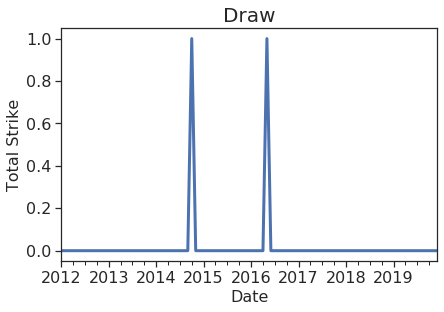

In [27]:
labels.loc[labels['NumberId'] == 9016].set_index('cutoff_time')['TotalStrike'].plot(figsize = (6, 4), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Total Strike', size = 16); 
plt.title('Draw', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

In [28]:
labels.tail(10)

,NumberId,cutoff_time,TotalStrike,Label
9990,4949,2019-12-01,0.0,0
9991,3479,2019-12-01,0.0,0
9992,6512,2019-12-01,0.0,0
9993,4996,2019-12-01,0.0,0
9994,3852,2019-12-01,0.0,0
9995,7940,2019-12-01,0.0,0
9996,5407,2019-12-01,0.0,0
9997,7709,2019-12-01,0.0,0
9998,9659,2019-12-01,0.0,0
9999,5488,2019-12-01,0.0,0


## Automated Feature Engineering

In [29]:
es = ft.EntitySet(id="Lotto Results")

# Add the entire data table as an entity
es.entity_from_dataframe("Results",
                         dataframe=data,
                         index="results_index",
                         time_index = 'DrawDate')

es['Results']

2020-01-06 14:41:17,714 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: Results
  Variables:
    results_index (dtype: index)
    DrawNo (dtype: numeric)
    DrawDate (dtype: datetime_time_index)
    PrizeType (dtype: categorical)
    LuckyNo (dtype: numeric)
    NumberId (dtype: numeric)
    TotalStrike (dtype: numeric)
  Shape:
    (Rows: 106858, Columns: 7)

In [30]:
es.normalize_entity(new_entity_id="Numbers",
                    base_entity_id="Results",
                    index="NumberId",
                    )

Entityset: Lotto Results
  Entities:
    Results [Rows: 106858, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [31]:
es

Entityset: Lotto Results
  Entities:
    Results [Rows: 106858, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [32]:
es['Numbers'].df.head(24)

,NumberId,first_Results_time
19,19,1992-05-06 00:01:00
1124,1124,1992-05-06 00:01:00
592,592,1992-05-06 00:01:00
5311,5311,1992-05-06 00:01:00
407,407,1992-05-06 00:01:00
1949,1949,1992-05-06 00:01:00
1606,1606,1992-05-06 00:01:00
3775,3775,1992-05-06 00:01:00
6226,6226,1992-05-06 00:01:00
1271,1271,1992-05-06 00:01:00


In [33]:
es['Results'].df.head(24)

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,0,40792,1992-05-06 00:01:00,Prize,19,19,1
1,1,40792,1992-05-06 00:01:00,Prize,1124,1124,1
2,2,40792,1992-05-06 00:01:00,Prize,592,592,1
3,3,40792,1992-05-06 00:01:00,Prize,5311,5311,1
4,4,40792,1992-05-06 00:01:00,Prize,407,407,1
5,5,40792,1992-05-06 00:01:00,Prize,1949,1949,1
6,6,40792,1992-05-06 00:01:00,Prize,1606,1606,1
7,7,40792,1992-05-06 00:01:00,Prize,3775,3775,1
8,8,40792,1992-05-06 00:01:00,Prize,6226,6226,1
9,9,40792,1992-05-06 00:01:00,Prize,1271,1271,1


In [34]:
len(es['Results'].df)

106858

## Deep Feature Synthesis

In [ ]:
# feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
#                                         cutoff_time = labels, verbose = 2,
#                                         cutoff_time_in_index = True,
#                                         chunk_size = len(labels), n_jobs = 1,
#                                         max_depth = 1)

In [36]:
default_agg_primitives =  ['std', 'max', 'min', 'mode', 'mean', 'skew', 'last', 'avg_time_between', 
                             'count', 'sum', 'trend', 'percent_true', 'num_unique']
default_trans_primitives =  ['cum_sum', 'cum_mean', 'day', 'month', 'hour', 'percentile', 
                             'and', 'time_since', 'days_since', 'time_since_previous']

feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
                                        agg_primitives = default_agg_primitives ,
                                        trans_primitives = default_trans_primitives,
                                        cutoff_time = labels, verbose = 1,
                                        cutoff_time_in_index = True,
                                        chunk_size = len(labels), n_jobs = 1,
                                        max_depth = 2)

Built 207 features
Elapsed: 9:24:20 | Progress: 100%|██████████


In [37]:
len(feature_matrix.columns), feature_matrix.columns

(209, Index(['STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
        'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
        'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
        'MIN(Results.DrawNo)', 'MODE(Results.PrizeType)',
        ...
        'PERCENTILE(MIN(Results.LuckyNo))',
        'PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate))',
        'PERCENTILE(MAX(Results.DrawNo))',
        'PERCENTILE(TREND(Results.LuckyNo, DrawDate))',
        'PERCENTILE(LAST(Results.TotalStrike))',
        'PERCENTILE(LAST(Results.LuckyNo))',
        'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
        'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label'],
       dtype='object', length=209))

In [38]:
len(feature_matrix)

959893

In [39]:
feature_matrix.head().T

NumberId,72,98,121,166,192
time,2012-01-01,2012-01-01,2012-01-01,2012-01-01,2012-01-01
STD(Results.LuckyNo),0,0,0,0,0
STD(Results.TotalStrike),0,0,0,0,0
STD(Results.DrawNo),75380.4,111281,60627.5,104465,87114.8
MAX(Results.LuckyNo),72,98,121,166,192
MAX(Results.TotalStrike),1,1,1,1,1
...,...,...,...,...,...
PERCENTILE(LAST(Results.LuckyNo)),0.00730365,0.00990495,0.0122061,0.0167084,0.0193097
PERCENTILE(NUM_UNIQUE(Results.PrizeType)),0.50005,0.50005,0.50005,0.50005,0.50005
PERCENTILE(MEAN(Results.DrawNo)),0.654777,0.252926,0.795798,0.682441,0.932816


In [40]:
feature_matrix.shape

(959893, 209)

In [41]:
feature_matrix.head(2)

,,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MODE(Results.PrizeType),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.PrizeType),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(MIN(Results.LuckyNo)),CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate)),CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label
NumberId,time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72,2012-01-01,0.0,0.0,75380.359429,72,1,318809,72,1,137498,Prize,72,1,216252.75,0.0,0.0,0.910970,72,1,63949,Prize,318809,1.152288e+08,4,288,4,865011,0.0,0.0,0.031519,1,8,7,0,425519940.0,37688.804474,1.434912e+08,0.233506,8.636342e+07,17337.064582,0.0,...,5001.486844,8.334835e+07,320235.911096,0.0,1.0,5001.486844,1.0,196252.105443,21,6,0,0.50005,0.50005,0.005203,0.843635,0.145223,0.098999,0.098999,0.007304,0.50005,0.893547,0.50005,0.500051,0.500051,0.895006,0.355428,0.500051,0.007304,0.50005,0.216811,0.007304,0.860715,0.355428,0.500051,0.50005,0.007304,0.50005,0.654777,1.0,1
98,2012-01-01,0.0,0.0,111281.080099,98,1,328109,98,1,42692,Prize,98,1,178250.50,0.0,0.0,-0.071903,98,1,66090,Prize,328109,7.900663e+07,8,784,8,1426004,0.0,0.0,0.030838,1,18,6,0,616550340.0,55641.739761,2.164907e+08,0.344716,1.274658e+08,25596.272441,0.0,...,5043.793911,8.432840e+07,320338.948478,0.0,1.0,5043.793911,1.0,182088.440653,27,12,0,0.50005,0.50005,0.013207,0.132010,0.486043,0.604402,0.604402,0.009905,0.50005,0.043422,0.50005,0.500051,0.500051,0.461625,0.440070,0.500051,0.009905,0.50005,0.851075,0.009905,0.588170,0.440070,0.500051,0.50005,0.009905,0.50005,0.252926,1.0,1


In [ ]:
#feature_matrix[(feature_matrix['NumberId']==0) & (feature_matrix['Label']==1)].head(10)

## Correlations

In [43]:
# Save the original feature matrix
origin_feature_matrix = feature_matrix

feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(959893, 211)

In [44]:
feature_matrix.head(10)

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
0,72,2012-01-01,0.0,0.0,75380.359429,72,1,318809,72,1,137498,72,1,216252.750,0.0,0.0,0.910970,72,1,63949,318809,1.152288e+08,4,288,4,865011,0.0,0.0,0.031519,1,8,7,0,425519940.0,37688.804474,1.434912e+08,0.233506,8.636342e+07,17337.064582,0.0,...,320235.911096,0.0,1.0,5001.486844,1.0,196252.105443,21,6,0,0.50005,0.50005,0.005203,0.843635,0.145223,0.098999,0.098999,0.007304,0.50005,0.893547,0.50005,0.500051,0.500051,0.895006,0.355428,0.500051,0.007304,0.50005,0.216811,0.007304,0.860715,0.355428,0.500051,0.50005,0.007304,0.50005,0.654777,1.0,1,1,1
1,98,2012-01-01,0.0,0.0,111281.080099,98,1,328109,98,1,42692,98,1,178250.500,0.0,0.0,-0.071903,98,1,66090,328109,7.900663e+07,8,784,8,1426004,0.0,0.0,0.030838,1,18,6,0,616550340.0,55641.739761,2.164907e+08,0.344716,1.274658e+08,25596.272441,0.0,...,320338.948478,0.0,1.0,5043.793911,1.0,182088.440653,27,12,0,0.50005,0.50005,0.013207,0.132010,0.486043,0.604402,0.604402,0.009905,0.50005,0.043422,0.50005,0.500051,0.500051,0.461625,0.440070,0.500051,0.009905,0.50005,0.851075,0.009905,0.588170,0.440070,0.500051,0.50005,0.009905,0.50005,0.252926,1.0,1,1,1
2,121,2012-01-01,0.0,0.0,60627.517299,121,1,288507,121,1,141698,121,1,232103.500,0.0,0.0,-0.742656,121,1,56980,288507,5.588352e+07,6,726,6,1392621,0.0,0.0,0.031519,1,11,10,0,417311940.0,30304.837474,1.154084e+08,0.187748,6.926576e+07,13941.128511,0.0,...,320292.638369,0.0,1.0,5002.939931,1.0,196627.205652,19,8,0,0.50005,0.50005,0.012606,0.843840,0.464432,0.323162,0.323162,0.012206,0.50005,0.902801,0.50005,0.500051,0.500051,0.148997,0.176288,0.500051,0.012206,0.50005,0.090380,0.012206,0.233481,0.176288,0.500051,0.50005,0

In [45]:
corrs = feature_matrix.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

CUM_MEAN(SUM(Results.LuckyNo))      -0.003148
MAX(Results.TIME_SINCE(DrawDate))   -0.002875
TIME_SINCE(first_Results_time)      -0.002875
CUM_MEAN(STD(Results.DrawNo))       -0.002662
MAX(Results.PERCENTILE(LuckyNo))    -0.002585
Name: TotalStrike, dtype: float64

In [46]:
corrs['TotalStrike'].dropna().tail(60)

MODE(Results.DAY(DrawDate))                         0.000479
PERCENTILE(SUM(Results.DrawNo))                     0.000518
TREND(Results.PERCENTILE(LuckyNo), DrawDate)        0.000615
SKEW(Results.TIME_SINCE(DrawDate))                  0.000718
MONTH(first_Results_time)                           0.000787
MIN(Results.TIME_SINCE(DrawDate))                   0.000824
LAST(Results.TIME_SINCE(DrawDate))                  0.000824
LAST(Results.CUM_MEAN(LuckyNo))                     0.000834
CUM_SUM(SUM(Results.DrawNo))                        0.000892
MAX(Results.CUM_MEAN(LuckyNo))                      0.000980
PERCENTILE(MEAN(Results.DrawNo))                    0.001022
MEAN(Results.PERCENTILE(DrawNo))                    0.001110
CUM_SUM(STD(Results.DrawNo))                        0.001203
PERCENTILE(TREND(Results.DrawNo, DrawDate))         0.001238
CUM_SUM(SUM(Results.LuckyNo))                       0.001240
CUM_SUM(COUNT(Results))                             0.001242
CUM_SUM(SUM(Results.Tota

In [ ]:
feature_matrix['month'] = feature_matrix['time'].dt.month
feature_matrix['year'] = feature_matrix['time'].dt.year

In [48]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 213 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(2)
memory usage: 1.5 GB


In [49]:
feature_matrix.head()

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
0,72,2012-01-01,0.0,0.0,75380.359429,72,1,318809,72,1,137498,72,1,216252.75,0.0,0.0,0.910970,72,1,63949,318809,1.152288e+08,4,288,4,865011,0.0,0.0,0.031519,1,8,7,0,425519940.0,37688.804474,1.434912e+08,0.233506,8.636342e+07,17337.064582,0.0,...,1.0,5001.486844,1.0,196252.105443,21,6,0,0.50005,0.50005,0.005203,0.843635,0.145223,0.098999,0.098999,0.007304,0.50005,0.893547,0.50005,0.500051,0.500051,0.895006,0.355428,0.500051,0.007304,0.50005,0.216811,0.007304,0.860715,0.355428,0.500051,0.50005,0.007304,0.50005,0.654777,1.0,1,1,1,1,2012
1,98,2012-01-01,0.0,0.0,111281.080099,98,1,328109,98,1,42692,98,1,178250.50,0.0,0.0,-0.071903,98,1,66090,328109,7.900663e+07,8,784,8,1426004,0.0,0.0,0.030838,1,18,6,0,616550340.0,55641.739761,2.164907e+08,0.344716,1.274658e+08,25596.272441,0.0,...,1.0,5043.793911,1.0,182088.440653,27,12,0,0.50005,0.50005,0.013207,0.132010,0.486043,0.604402,0.604402,0.009905,0.50005,0.043422,0.50005,0.500051,0.500051,0.461625,0.440070,0.500051,0.009905,0.50005,0.851075,0.009905,0.588170,0.440070,0.500051,0.50005,0.009905,0.50005,0.252926,1.0,1,1,1,1,2012
2,121,2012-01-01,0.0,0.0,60627.517299,121,1,288507,121,1,141698,121,1,232103.50,0.0,0.0,-0.742656,121,1,56980,288507,5.588352e+07,6,726,6,1392621,0.0,0.0,0.031519,1,11,10,0,417311940.0,30304.837474,1.154084e+08,0.187748,6.926576e+07,13941.128511,0.0,...,1.0,5002.939931,1.0,196627.205652,19,8,0,0.50005,0.50005,0.012606,0.843840,0.464432,0.323162,0.323162,0.012206,0.50005,0.902801,0.50005,0.500051,0.500051,0.148997,0.176288,0.500051,0.012206,0.50005,0.090380,0.012206,0.233481,0.176288,0.500051,0.50005,0.012206,0.50005,0.795798,1.0,1,1,1,1,2012
3,166,2012-01-01,0.0,0.0,104465.138948,166,1,362311,166,1,43492,1

In [50]:
feature_matrix.tail()

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
959888,7940,2019-12-01,0.0,0.0,43816.929073,7940,1,473918,7940,1,358611,7940,1,399980.166667,0.0,0.0,1.185862,7940,1,99633,473918,4.064256e+07,6,47640,6,2399881,0.0,0.0,0.034006,1,24,9,0,258335940.0,21914.057725,7.731018e+07,0.094611,5.009341e+07,10079.462261,0.0,...,1.0,4998.212406,1.0,272162.894602,3,3,0,0.50005,0.50005,0.49705,1.000000,0.3254,0.07015,0.07015,0.7941,0.50005,0.9995,0.50005,0.50005,0.50005,0.974877,0.49950,0.50005,0.7941,0.50005,0.0015,0.7941,0.0140,0.49950,0.50005,0.50005,0.7941,0.50005,0.9973,0.0,0,1,1,12,2019
959889,5407,2019-12-01,0.0,0.0,33816.271769,5407,1,426715,5407,1,366112,5407,1,405080.666667,0.0,0.0,-1.700598,5407,1,88778,426715,5.365440e+07,3,16221,3,1215242,0.0,0.0,0.033921,1,19,2,0,245548740.0,16897.356249,5.981441e+07,0.073018,3.854211e+07,7771.970235,0.0,...,1.0,4998.253301,1.0,272176.191698,15,7,0,0.50005,0.50005,0.16650,0.999700,0.0302,0.00400,0.00400,0.5408,0.50005,0.9996,0.50005,0.50005,0.50005,0.006206,0.16560,0.50005,0.5408,0.50005,0.0007,0.5408,0.1281,0.16560,0.50005,0.50005,0.5408,0.50005,0.9981,0.0,0,1,1,12,2019
959890,7709,2019-12-01,0.0,0.0,39368.855047,7709,1,501619,7709,1,373212,7709,1,438690.500000,0.0,0.0,0.112795,7709,1,105992,501619,3.264686e+07,8,61672,8,3509524,0.0,0.0,0.033760,1,15,7,0,232847940.0,19687.520845,6.996679e+07,0.085007,4.493147e+07,9055.400179,0.0,...,1.0,4998.524457,1.0,272192.848126,12,10,0,0.50005,0.50005,0.62920,0.997798,0.7429,0.21530,0.21530,0.7710,0.50005,0.9997,0.50005,0.50005,0.50005,0.585227,0.95045,0.50005,0.7710,0.50005,0.0011,0.7710,0.0013,0.95045,0.50005,0.50005,0.7710,0.50005,0.9998,0.0,0,1,1,12,2019
959891,9659,2019-12-01,0.0,0.0,30474.905355,9659,1,488518,9659,1,414714,9659,1,460600.0

In [51]:
display(feature_matrix.describe())

,NumberId,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
count,959893.000000,958948.0,958948.0,958948.000000,959893.000000,959893.0,959893.000000,959893.000000,959893.0,959893.000000,959893.000000,959893.0,959893.000000,952257.0,952257.0,952257.000000,959893.000000,959893.0,959893.000000,959893.000000,9.589480e+05,959893.000000,959893.000000,959893.000000,9.598930e+05,952257.0,952257.0,952257.000000,959893.0,959893.000000,959893.000000,959893.0,9.598930e+05,958948.000000,9.589480e+05,958948.000000,9.589480e+05,958948.000000,958948.0,958948.0,...,959893.0,959893.000000,959893.0,959893.000000,959893.000000,959893.000000,959893.0,9.598930e+05,9.589480e+05,959893.000000,952257.000000,959893.000000,959893.000000,959893.000000,959893.000000,9.598930e+05,959893.000000,9.589480e+05,9.522570e+05,9.522570e+05,952257.000000,959893.000000,9.522570e+05,959893.000000,9.598930e+05,958948.000000,959893.000000,958948.000000,959893.000000,9.522570e+05,9.598930e+05,959893.000000,9.598930e+05,959893.000000,959893.000000,959893.000000,959893.0,959893.0,959893.000000,959893.000000
mean,4999.183099,0.0,0.0,111342.196139,4999.183099,1.0,390906.910112,4999.183099,1.0,83952.251200,4999.183099,1.0,237399.507951,0.0,0.0,-0.001558,4999.183099,1.0,80532.690101,390906.910112,8.234844e+07,9.049760,45042.829158,9.049760,2.168381e+06,0.0,0.0,0.031651,1.0,15.660883,6.671245,0.0,6.586662e+08,55666.088612,2.109083e+08,0.282846,1.274557e+08,25606.239908,0.0,0.0,...,1.0,4997.239827,1.0,223470.762848,15.800966,6.507360,0.0,5.000500e-01,5.000501e-01,0.500050,0.500050,0.500050,0.500050,0.500050,0.500050,5.000500e-01,0.500050,5.000501e-01,5.000504e-01,5.000504e-01,0.500050,0.500050,5.000504e-01,0.500050,5.000500e-01,0.500050,0.500050,0.5

## Save feature matrix

In [ ]:
# https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
if COLAB:
  #!cd dl-projects && git config --global user.email 'mengwangk@gmail.com' 
  #!cd dl-projects && git config --global user.name 'mengwangk'
  #!cd dl-projects && git add -A && git commit -m 'Updated from colab' 
  # from google.colab import drive
  # drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')
  #!ls /content/gdrive/My\ Drive/
  
  # feature_matrix.to_csv(GDRIVE_DATASET_FOLDER/f"{FEATURE_DATASET_PREFIX}.csv", index=False)
  feature_matrix.to_pickle(GDRIVE_DATASET_FOLDER/f"{FEATURE_DATASET_PREFIX}.pkl")
  origin_feature_matrix.to_pickle(GDRIVE_DATASET_FOLDER/f"{FEATURE_DATASET_PREFIX}_origin.pkl")

In [ ]:
#if COLAB:
#  !cd dl-projects && git remote rm origin && git remote add origin https://mengwangk:XX@github.com/mengwangk/dl-projects.git && git push -u origin master

In [ ]:
# from google.colab import files
# files.download(DATASET_PATH/'feature_matrix.csv') 

In [55]:
if COLAB:
  !cd gdrive/"My Drive"/datasets/ && ls -l --block-size=M

total 4630M
-rw------- 1 root root 1555M Jan  5 23:01 feature_matrix_d2.pkl
-rw------- 1 root root 1528M Jan  7 00:07 feature_matrix_d2_v1_origin.pkl
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl


## Validation

#### Oct 2019

In [56]:
month_data = feature_matrix.loc[feature_matrix['time'] == pd.datetime(2019,10,1)]
len(month_data), month_data.columns

(10000,
 Index(['NumberId', 'time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
        'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
        'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
        ...
        'PERCENTILE(LAST(Results.TotalStrike))',
        'PERCENTILE(LAST(Results.LuckyNo))',
        'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
        'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
        'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize',
        'month', 'year'],
       dtype='object', length=213))

In [57]:
len(month_data[month_data['Label'] == 1]), len(month_data[month_data['TotalStrike'] == 1]), len(month_data[month_data['TotalStrike'] > 1])

(317, 312, 5)

In [58]:
display(month_data[month_data['Label'] == 1].head(3))

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
929893,31,2019-10-01,0.0,0.0,130965.773520,31,1,440116,31,1,50992,31,1,247677.181818,0.0,0.0,0.066238,31,1,91859,440116,73457280.0,11,341,11,2724449,0.0,0.0,0.031836,1,30,12,0,844214340.0,65487.754404,2.467564e+08,0.284492,1.499552e+08,30123.818135,0.0,...,1.0,4940.052506,1.0,251884.859130,10,4,0,0.50005,0.50005,0.0036,0.252803,0.4635,0.56945,0.56945,0.0032,0.50005,0.21005,0.50005,0.50005,0.50005,0.549960,0.24305,0.50005,0.0032,0.50005,0.4741,0.0032,0.4839,0.24305,0.50005,0.50005,0.0032,0.50005,0.2948,1.0,1,1,1,10,2019
929894,38,2019-10-01,0.0,0.0,106546.514619,38,1,470417,38,1,199902,38,1,355260.833333,0.0,0.0,-0.466415,38,1,98822,470417,98686080.0,6,228,6,2131565,0.0,0.0,0.032975,1,8,5,0,549071940.0,53276.947948,1.938447e+08,0.231459,1.219995e+08,24504.014809,0.0,...,1.0,5003.182451,1.0,268902.653326,26,12,0,0.50005,0.50005,0.0026,0.979275,0.2383,0.07290,0.07290,0.0039,0.50005,0.97660,0.50005,0.50005,0.50005,0.193432,0.49360,0.50005,0.0039,0.50005,0.1377,0.0039,0.7948,0.49360,0.50005,0.50005,0.0039,0.50005,0.9730,1.0,1,1,1,10,2019
929895,59,2019-10-01,0.0,0.0,147156.354939,59,1,478118,59,1,85795,59,1,274206.222222,0.0,0.0,0.338729,59,1,100593,478118,91540800.0,9,531,9,2467856,0.0,0.0,0.032361,1,19,3,0,774316740.0,73576.635638,2.727907e+08,0.319661,1.683506e+08,33844.100520,0.0,...,1.0,5001.260068,1.0,258107.045443,2,6,0,0.50005,0.50005,0.0061,0.816079,0.3613,0.33010,0.33010,0.0060,0.50005,0.64600,0.50005,0.50005,0.50005,0.737785,0.58770,0.50005,0.0060,0.50005,0.7632,0.0060,0.7305,0.58770,0.50005,0.50005,0.0060,0.50005,0.5317,1.0,1,1,1,10,2019


In [59]:
month_numbers = np.array([month_data[month_data['Label'] == 1]['NumberId']])[0]
len(month_numbers), np.sort(month_numbers)

(317, array([  31,   38,   59,  123,  127,  192,  208,  233,  277,  296,  305,
         310,  312,  318,  322,  354,  364,  417,  435,  443,  458,  460,
         469,  502,  540,  556,  565,  619,  631,  639,  659,  673,  717,
         795,  823,  841,  901,  910,  979,  998, 1004, 1007, 1023, 1069,
        1129, 1131, 1158, 1223, 1292, 1301, 1359, 1372, 1405, 1636, 1642,
        1657, 1667, 1680, 1715, 1781, 1813, 1836, 2033, 2059, 2136, 2140,
        2146, 2152, 2171, 2188, 2221, 2226, 2227, 2297, 2330, 2371, 2401,
        2472, 2563, 2584, 2604, 2621, 2623, 2665, 2687, 2773, 2808, 2810,
        2850, 2851, 2917, 2921, 2978, 2980, 2999, 3008, 3016, 3049, 3065,
        3082, 3132, 3141, 3142, 3162, 3223, 3300, 3305, 3328, 3341, 3342,
        3399, 3404, 3430, 3504, 3552, 3572, 3617, 3620, 3653, 3713, 3794,
        3802, 3869, 3876, 3882, 3883, 3916, 3917, 3929, 3986, 3996, 4015,
        4049, 4060, 4075, 4103, 4124, 4127, 4165, 4184, 4258, 4268, 4296,
        4353, 4370, 4418, 4460, 4

In [60]:
origin_month_numbers = np.array([data[ (data['DrawDate'].dt.year == 2019) & (data['DrawDate'].dt.month == 10) ]['LuckyNo']])[0]
len(origin_month_numbers), np.sort(origin_month_numbers)

(322, array([  31,   38,   59,  123,  127,  192,  208,  233,  277,  296,  305,
         310,  312,  318,  322,  354,  364,  417,  435,  443,  458,  460,
         469,  502,  540,  556,  565,  619,  631,  639,  659,  673,  717,
         795,  823,  841,  901,  910,  979,  998, 1004, 1007, 1023, 1069,
        1129, 1131, 1158, 1223, 1292, 1301, 1359, 1372, 1405, 1636, 1642,
        1657, 1667, 1680, 1715, 1781, 1813, 1836, 2033, 2059, 2136, 2140,
        2146, 2152, 2171, 2188, 2221, 2226, 2227, 2297, 2330, 2371, 2401,
        2472, 2563, 2584, 2604, 2621, 2623, 2665, 2687, 2773, 2808, 2810,
        2850, 2851, 2917, 2921, 2978, 2980, 2999, 3008, 3016, 3049, 3065,
        3082, 3132, 3141, 3142, 3162, 3223, 3300, 3305, 3328, 3341, 3342,
        3399, 3404, 3430, 3504, 3504, 3552, 3572, 3617, 3620, 3653, 3713,
        3794, 3802, 3869, 3876, 3882, 3883, 3916, 3917, 3929, 3986, 3996,
        4015, 4049, 4060, 4075, 4103, 4124, 4127, 4165, 4184, 4258, 4268,
        4296, 4353, 4370, 4418, 4

In [61]:
data[ (data['DrawDate'].dt.year == 2019) & (data['DrawDate'].dt.month == 10) & (data['LuckyNo'] == 7198) ]

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
106044,106044,501819,2019-10-16 00:01:00,Prize,7198,7198,1


In [62]:
month_data[month_data['TotalStrike'] == 1].sort_values(by=['MAX(Results.DrawNo)'], ascending=False)

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
930128,7198,2019-10-01,0.0,0.0,162919.721097,7198,1,500819,7198,1,71194,7198,1,292516.181818,0.0,0.0,-0.191816,7198,1,105816,500819,8.030880e+07,11,79178,11,3217678,0.0,0.0,0.032100,1,14,4,0,803606340.0,81452.541733,3.044540e+08,0.353921,1.863592e+08,37467.372350,0.0,...,1.0,5016.086698,1.0,255233.618511,25,9,0,0.50005,0.50005,0.77340,0.565979,0.6621,0.56945,0.56945,0.7199,0.50005,0.50455,0.50005,0.50005,0.50005,0.353324,0.9943,0.50005,0.7199,0.50005,0.9298,0.7199,0.5954,0.9943,0.50005,0.50005,0.7199,0.50005,0.6972,1.0,1,1,1,10,2019
929952,1781,2019-10-01,0.0,0.0,130589.424972,1781,1,500719,1781,1,65993,1781,1,300761.461538,0.0,0.0,0.073510,1781,1,105792,500719,6.776640e+07,13,23153,13,3909899,0.0,0.0,0.032424,1,15,12,0,813974340.0,65285.818204,2.415735e+08,0.283669,1.494005e+08,30029.494169,0.0,...,1.0,4983.732895,1.0,254304.485383,22,9,0,0.50005,0.50005,0.24200,0.850621,0.8525,0.77600,0.77600,0.1782,0.50005,0.44100,0.50005,0.50005,0.50005,0.556868,0.9920,0.50005,0.1782,0.50005,0.4690,0.1782,0.3861,0.9920,0.50005,0.50005,0.1782,0.50005,0.7601,1.0,1,1,1,10,2019
929962,2188,2019-10-01,0.0,0.0,99931.348745,2188,1,500719,2188,1,146999,2188,1,328899.300000,0.0,0.0,-0.025967,2188,1,105798,500719,7.227840e+07,10,21880,10,3288993,0.0,0.0,0.032747,1,10,2,0,651283140.0,49963.831863,1.830502e+08,0.217088,1.142586e+08,22982.107187,0.0,...,1.0,5003.578861,1.0,265792.923974,22,9,0,0.50005,0.50005,0.22860,0.952643,0.6853,0.45085,0.45085,0.2189,0.50005,0.91285,0.50005,0.50005,0.50005,0.477473,0.9920,0.50005,0.2189,0.50005,0.0880,0.2189,0.4642,0.9920,0.50005,0.50005,0.2189,0.50005,0.9122,1.0,1,1,1,10,2019
930034,4268,2019-10-01,0.0,0.0,103519.404637,4268,1,500619,4268,1,186401,4268,

In [63]:
data[ (data['LuckyNo'] == 7198) ]

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
7014,7014,71194,1994-04-14 00:01:00,Prize,7198,7198,1
8861,8861,79294,1994-10-19 00:01:00,Prize,7198,7198,1
19467,19467,125397,1997-09-28 00:01:00,Prize,7198,7198,1
23820,23820,144298,1998-12-09 00:01:00,Prize,7198,7198,1
58464,58464,294908,2008-01-06 00:01:00,Prize,7198,7198,1
62079,62079,310708,2008-12-27 00:01:00,Prize,7198,7198,1
74405,74405,364312,2012-01-17 00:01:00,Prize,7198,7198,1
80424,80424,390413,2013-06-30 00:01:00,Prize,7198,7198,1
93385,93385,446816,2016-08-31 00:01:00,Prize,7198,7198,1
103206,103206,489519,2019-01-23 00:01:00,Prize,7198,7198,1


### Dec 2019

In [64]:
month_data = feature_matrix.loc[feature_matrix['time'] == pd.datetime(2019,12,1)]
len(month_data), month_data.columns

(10000,
 Index(['NumberId', 'time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
        'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
        'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
        ...
        'PERCENTILE(LAST(Results.TotalStrike))',
        'PERCENTILE(LAST(Results.LuckyNo))',
        'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
        'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
        'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize',
        'month', 'year'],
       dtype='object', length=213))

In [65]:
len(month_data[month_data['Label'] == 1]), len(month_data[month_data['TotalStrike'] == 1]), len(month_data[month_data['TotalStrike'] > 1])

(316, 310, 6)

In [66]:
display(month_data[month_data['Label'] == 1].head(3))

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
949893,26,2019-12-01,0.0,0.0,128660.196406,26,1,476718,26,1,80794,26,1,316448.600000,0.0,0.0,-0.407578,26,1,100258,476718,82176000.0,10,260,10,3164486,0.0,0.0,0.032351,1,23,11,0,789609540.0,64332.707596,2.385369e+08,0.277807,1.472646e+08,29590.903862,0.0,...,1.0,5007.831229,1.0,258518.188900,1,5,0,0.50005,0.50005,0.0029,0.802522,0.6300,0.44340,0.44340,0.0027,0.50005,0.60195,0.50005,0.50005,0.50005,0.219097,0.53150,0.50005,0.0027,0.50005,0.4175,0.0027,0.6225,0.53150,0.50005,0.50005,0.0027,0.50005,0.8503,1.0,1,1,1,12,2019
949894,57,2019-12-01,0.0,0.0,127533.200161,57,1,466617,57,1,87695,57,1,286624.909091,0.0,0.0,-0.114390,57,1,97942,466617,70796160.0,11,627,11,3152874,0.0,0.0,0.032181,1,3,5,0,775699140.0,63772.612494,2.377116e+08,0.275374,1.459847e+08,29333.845044,0.0,...,1.0,5000.166541,1.0,259736.831176,8,10,0,0.50005,0.50005,0.0075,0.648083,0.6258,0.56205,0.56205,0.0058,0.50005,0.66105,0.50005,0.50005,0.50005,0.408267,0.42130,0.50005,0.0058,0.50005,0.3994,0.0058,0.4396,0.42130,0.50005,0.50005,0.0058,0.50005,0.6338,1.0,1,1,1,12,2019
949895,74,2019-12-01,0.0,0.0,153375.286298,74,1,488819,74,1,82194,74,1,293319.625000,0.0,0.0,-0.236685,74,1,103042,488819,108345600.0,8,592,8,2346557,0.0,0.0,0.032111,1,25,12,0,786844740.0,76687.573194,2.865106e+08,0.331173,1.754841e+08,35275.072380,0.0,...,1.0,5012.031377,1.0,258828.396659,6,1,0,0.50005,0.50005,0.0071,0.560504,0.3062,0.21530,0.21530,0.0075,0.50005,0.61505,0.50005,0.50005,0.50005,0.322390,0.70945,0.50005,0.0075,0.50005,0.8364,0.0075,0.8534,0.70945,0.50005,0.50005,0.0075,0.50005,0.6918,1.0,1,1,1,12,2019


In [67]:
month_numbers = np.array([month_data[month_data['Label'] == 1]['NumberId']])[0]
len(month_numbers), np.sort(month_numbers)

(316, array([  26,   57,   74,  135,  153,  155,  197,  215,  296,  322,  489,
         491,  501,  545,  554,  559,  572,  594,  622,  636,  646,  708,
         729,  780,  836,  838,  876,  920,  941,  943,  946, 1001, 1007,
        1013, 1082, 1108, 1116, 1134, 1145, 1156, 1245, 1325, 1331, 1368,
        1370, 1396, 1401, 1421, 1438, 1443, 1460, 1499, 1510, 1514, 1515,
        1532, 1546, 1634, 1677, 1685, 1711, 1782, 1815, 1833, 1859, 1899,
        1932, 1964, 1990, 1995, 2035, 2083, 2092, 2207, 2213, 2224, 2236,
        2281, 2283, 2321, 2389, 2398, 2424, 2430, 2438, 2440, 2513, 2519,
        2528, 2539, 2568, 2657, 2739, 2768, 2772, 2803, 2810, 2817, 2858,
        2885, 2910, 2965, 3002, 3011, 3021, 3026, 3049, 3052, 3074, 3094,
        3097, 3098, 3143, 3148, 3155, 3176, 3185, 3191, 3253, 3311, 3396,
        3402, 3414, 3497, 3505, 3566, 3588, 3607, 3626, 3639, 3640, 3649,
        3702, 3727, 3736, 3782, 3791, 3920, 3921, 3961, 3972, 3977, 4037,
        4090, 4124, 4171, 4232, 4

In [68]:
origin_month_numbers = np.array([data[ (data['DrawDate'].dt.year == 2019) & (data['DrawDate'].dt.month == 12) ]['LuckyNo']])[0]
len(origin_month_numbers), np.sort(origin_month_numbers)

(322, array([  26,   57,   74,  135,  135,  153,  155,  197,  215,  296,  322,
         489,  491,  501,  545,  554,  559,  572,  594,  622,  636,  646,
         708,  729,  780,  836,  838,  876,  920,  941,  943,  946, 1001,
        1007, 1013, 1082, 1108, 1116, 1134, 1145, 1156, 1245, 1325, 1331,
        1368, 1370, 1396, 1401, 1421, 1438, 1443, 1460, 1499, 1510, 1514,
        1515, 1532, 1546, 1634, 1677, 1685, 1711, 1782, 1815, 1833, 1859,
        1899, 1932, 1964, 1990, 1995, 2035, 2083, 2092, 2207, 2213, 2224,
        2236, 2281, 2283, 2321, 2389, 2398, 2424, 2430, 2438, 2440, 2513,
        2513, 2519, 2528, 2539, 2568, 2657, 2739, 2768, 2772, 2803, 2810,
        2817, 2858, 2885, 2910, 2965, 3002, 3011, 3021, 3026, 3049, 3052,
        3074, 3094, 3097, 3098, 3143, 3148, 3155, 3176, 3185, 3191, 3253,
        3311, 3396, 3402, 3414, 3497, 3505, 3566, 3588, 3607, 3626, 3639,
        3640, 3649, 3702, 3727, 3736, 3782, 3791, 3920, 3921, 3961, 3972,
        3977, 4037, 4090, 4124, 4

In [69]:
month_data[month_data['TotalStrike'] == 1].sort_values(by=['MAX(Results.DrawNo)'], ascending=False)

,NumberId,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),...,CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize,month,year
950024,3649,2019-12-01,0.0,0.0,126140.803111,3649,1,503819,3649,1,87595,3649,1,346101.181818,0.0,0.0,-0.988433,3649,1,106500,503819,7.758720e+07,11,40139,11,3807113,0.0,0.0,0.032244,1,30,4,0,775958340.0,63063.778939,2.346560e+08,0.272368,1.442383e+08,29008.657577,0.0,...,1.0,5002.455564,1.0,259719.138370,30,11,0,0.50005,0.50005,0.4207,0.714943,0.8213,0.56205,0.56205,0.3650,0.50005,0.66025,0.50005,0.50005,0.50005,0.046742,0.99890,0.50005,0.3650,0.50005,0.3737,0.3650,0.55775,0.99890,0.50005,0.50005,0.3650,0.50005,0.9532,1.0,1,1,1,12,2019
950121,7087,2019-12-01,0.0,0.0,185324.499476,7087,1,503519,7087,1,59493,7087,1,279420.428571,0.0,0.0,-0.027034,7087,1,106440,503519,1.386288e+08,7,49609,7,1955943,0.0,0.0,0.032056,1,15,7,0,832463940.0,92666.646412,3.468165e+08,0.400159,2.120625e+08,42625.665629,0.0,...,1.0,5007.598101,1.0,254829.870798,23,11,0,0.50005,0.50005,0.5172,0.494145,0.1736,0.13030,0.13030,0.7088,0.50005,0.34780,0.50005,0.50005,0.50005,0.475728,0.99215,0.50005,0.7088,0.50005,0.9925,0.7088,0.94660,0.99215,0.50005,0.50005,0.7088,0.50005,0.5665,1.0,1,1,1,12,2019
950172,8654,2019-12-01,0.0,0.0,158760.966686,8654,1,503519,8654,1,60193,8654,1,280453.066667,0.0,0.0,0.025949,8654,1,106429,503519,5.930743e+07,15,129810,15,4206796,0.0,0.0,0.032144,1,1,8,0,830995140.0,79379.757263,2.962800e+08,0.342802,1.816643e+08,36513.631641,0.0,...,1.0,5006.292506,1.0,254868.447651,23,11,0,0.50005,0.50005,0.9725,0.604144,0.8999,0.90180,0.90180,0.8655,0.50005,0.35760,0.50005,0.50005,0.50005,0.520268,0.99215,0.50005,0.8655,0.50005,0.8977,0.8655,0.22120,0.99215,0.50005,0.50005,0.8655,0.50005,0.5759,1.0,1,1,1,12,2019
949911,622,2019-12-01,0.0,0.0,91630.124177,622,1,503419,622,1,245605,622

In [70]:
data[ (data['LuckyNo'] == 3649) ]

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
10782,10782,87595,1995-04-30 00:01:00,Prize,3649,3649,1
26850,26850,157499,1999-09-26 00:01:00,Prize,3649,3649,1
65326,65326,324809,2009-10-21 00:01:00,Prize,3649,3649,1
68269,68269,337610,2010-07-10 00:01:00,Prize,3649,3649,1
69236,69236,341810,2010-10-06 00:01:00,Prize,3649,3649,1
74016,74016,362611,2011-12-11 00:01:00,Prize,3649,3649,1
78757,78757,383213,2013-02-05 00:01:00,Prize,3649,3649,1
82534,82534,399614,2014-01-07 00:01:00,Prize,3649,3649,1
85636,85636,413114,2014-10-11 00:01:00,Prize,3649,3649,1
104566,104566,495419,2019-06-01 00:01:00,Prize,3649,3649,1
